In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from scipy.io import loadmat

from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting, surface, datasets
import nibabel

from numpy.matlib import repmat

from utils.io import get_args

/opt/homebrew/Caskroom/miniforge/base/envs/accel/lib/python3.10/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
args = get_args()

In [3]:
shen_network_labels = loadmat('Shen_network_labels.mat')
network_mappings = shen_network_labels['Shen_network_labels'].flatten()
network_names = ['medialfrontal', 'frontalparietal', 'default', 'subcorticalcerebellar', 'motor', 'visual2', 'visual1', 'visualassociation']

In [4]:
shen_mask = NiftiLabelsMasker(args.atlas_loc)

_ = shen_mask.fit_transform(args.atlas_loc)

In [8]:
fsaverage = datasets.fetch_surf_fsaverage("fsaverage")

def vol_to_surf_to_map(img, **plotting_kwargs):
    

    figure, axes = plt.subplots(2,2, subplot_kw={'projection': '3d'})
    for j, side in enumerate(['left', 'right']):
        bg_map = surface.load_surf_data(fsaverage[f"sulc_{side}"])
        for i, view in enumerate(['lateral', 'medial']):

            surf_data = surface.vol_to_surf(img,
                surf_mesh=fsaverage[f"pial_{side}"],
                inner_mesh=fsaverage[f"white_{side}"],
                interpolation='nearest'
            )

            fig = plotting.plot_surf_stat_map(
                fsaverage[f'pial_{side}'],
                surf_data,
                hemi=side,
                bg_map=bg_map,
                view=view,
                colorbar=False,
                axes=axes[i,j],
                **plotting_kwargs
            )

    plt.tight_layout()
    plt.savefig('results/figures/shen_2mm_268_parcellation_surface_projected.png', bbox_inches="tight", dpi=400, transparent=True)
    plt.show()
    plt.close()

In [6]:
colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple']
ncolors = len(colors)
expanded_colors = (['gray'] * (ncolors+1)) + colors
cmap = ListedColormap(expanded_colors)

roi_nums = repmat(np.arange(1, ncolors+1), n=int(np.ceil(268/ncolors)), m=1)[0][:268]


shen_img = nibabel.load(shen_mask.labels_img)
shen_data = shen_img.get_fdata()
for i in range(1, 269):
    shen_data[shen_data==i] = roi_nums[i-1]

updated_shen_img = nibabel.Nifti1Image(shen_data, shen_img.affine, shen_img.header)

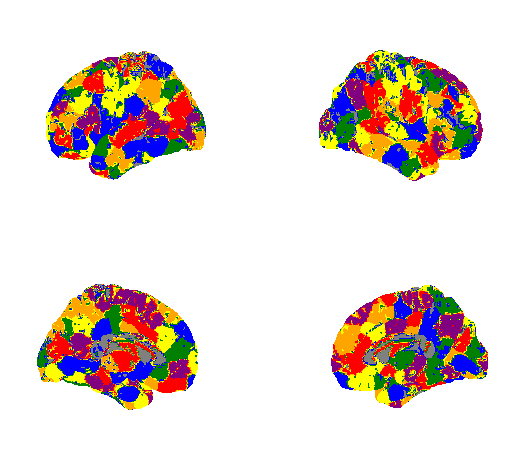

In [9]:
vol_to_surf_to_map(updated_shen_img, cmap=cmap)